# Вариант 22

In [1]:
import matplotlib.pyplot as plt
import sympy
import numpy as np
import control as ct

dt = 0.001

In [2]:
def sympy_frac_to_tf(frac):
    num = list(map(float, sympy.Poly(sympy.fraction(frac)[0], s).all_coeffs()))
    den = list(map(float, sympy.Poly(sympy.fraction(frac)[1], s).all_coeffs()))
    
    return ct.tf(
        num,
        den
    )

## Задание 1 

Дана система вида $ a_2 \ddot y + a_1 \dot y + a_0 u = u $.
Регулятор выбран в виде $ u = k_0 y + k_1 \dot y $.

In [3]:
k0, k1, a0, a1, a2, s = sympy.symbols('k_0 k_1 a_0 a_1 a_2 s')

In [4]:
l1, l2 = sympy.symbols('l_1 l_2')

In [5]:
lambdas = [
    -2,
    1
]

In [6]:
sol = sympy.solve([lambdas[0] + lambdas[1] + a1, lambdas[0]*lambdas[1] - a0], a0, a1, dict=True)[0]
sol

{a_0: -2, a_1: 1}

In [7]:
a = [
    float(sol[a0]),
    float(sol[a1]),
    1.
]
k = [
    -13/4,
    -2.
]

In [8]:
W_open_tf = ct.tf(
    [1.],
    [a[2], a[1], a[0]]
)

In [9]:
sys_open = ct.canonical_form(ct.tf2ss(W_open_tf), 'reachable')[0]

In [10]:
sec = 10
time = np.linspace(0, sec, int(sec/dt))
init_state_1 = [1, 0]
y_an = 1/2*np.exp(-1/2*time)-1/2*np.exp(-5/2*time)

In [11]:
y_open = ct.forced_response(
    ct.tf2ss(W_open_tf),
    T=time,
    X0=init_state_1,
).outputs

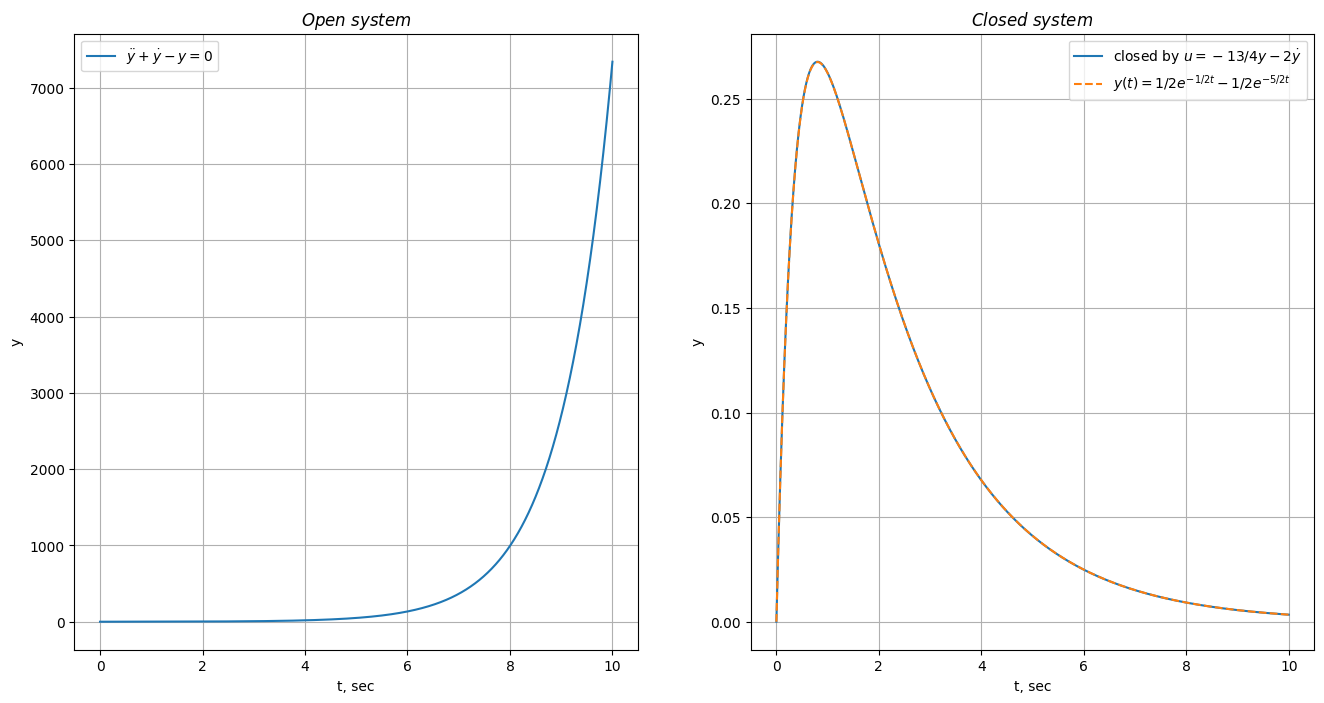

In [12]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(16,8)
)

ax[0].plot(time,y_open, label="$\ddot y + \dot y - y = 0$")
ax[0].set_ylabel("y")
ax[0].set_xlabel("t, sec")
ax[0].set_title("$Open \ system$")
ax[0].grid(True)
ax[0].legend()

state = init_state_1
y_ideal_closed = [state[1]]*2
for i in range(len(time)-1):
    u = k[0]*y_ideal_closed[-1] + k[1] * (y_ideal_closed[-1] - y_ideal_closed[-2]) / dt
    response = ct.forced_response(
        sys_open,
        T=time[i:i+2],
        X0=state,
        U=u
    )
    resp = response.outputs[-1]
    y_ideal_closed.append(resp)
    state = response.states[:,-1].flatten()

y_ideal_closed = y_ideal_closed[1:]    
ax[1].plot(time,y_ideal_closed, label="closed by $u = -13/4y -2\dot y$")
ax[1].plot(time,y_an, linestyle="dashed", label="$y(t) = 1/2e^{-1/2t}-1/2e^{-5/2t}$")
ax[1].set_ylabel("y")
ax[1].set_xlabel("t, sec")
ax[1].set_title("$Closed \ system$")
ax[1].grid(True)
ax[1].legend()

# Задание 2

In [35]:
T = sympy.Symbol('T')

In [36]:
W_open = 1 / (a2*s**2 + a1*s + a0)

In [37]:
W = W_open * (k0 + k1 * s / (T*s + 1) )
W_gy_2 = W / (1 - W)
W_gy_2 = W_gy_2.simplify()

In [38]:
W_gy_2 = W_gy_2.subs({
    a0: a[0],
    a1: a[1],
    a2: a[2],
    k0: k[0],
    k1: k[1]
})

In [39]:
W_gy_2

(-3.25*T*s - 2.0*s - 3.25)/(-3.25*T*s - 2.0*s + (T*s + 1)*(1.0*s**2 + 1.0*s - 2.0) - 3.25)

In [40]:
num, den = sympy.fraction(W_gy_2)
print("Numerator: ", num.expand().collect(s))
print("Denominator: ", den.expand().collect(s))

Numerator:  s*(-3.25*T - 2.0) - 3.25
Denominator:  1.0*T*s**3 + s**2*(1.0*T + 1.0) + s*(-5.25*T - 1.0) - 5.25


In [29]:
T_coeffs = [0.001, 0.01, 0.3]

In [30]:
stable = [W_gy_2.subs({
    T: coeff
}) for coeff in T_coeffs]

stable_ss = [ct.canonical_form(ct.tf2ss(sympy_frac_to_tf(st)), "reachable")[0] for st in stable]

так как системы имеют свои н.у. согласно преобразованиям, необходимо "подогнать" их под наши н.у.

In [31]:
sec = 10
time = np.linspace(0, sec, int(sec/dt))
init_state_2 = [0,1,0]

In [32]:
def set_x0(ss, state):
    x_1, x_2, x_3 = sympy.symbols("x_1 x_2 x_3")
    sol = sympy.solve([
        ss.C[0][1]*x_2 + ss.C[0][2]*x_3 - state[0],
        ss.C[0][1]*x_1 + ss.C[0][2]*x_2 - state[1],
        ss.C[0][1]*(ss.A[0][0]*x_1+ss.A[0][1]*x_2+ss.A[0][2]*x_3) + ss.C[0][2]*x_1 - state[2]
    ])
    return list(map(float,[sol[x_1],sol[x_2],sol[x_3]]))

In [33]:
y_2 = [ct.forced_response(
    sys=ss,
    T=time,
    X0=set_x0(ss, init_state_2)
) for ss in stable_ss]

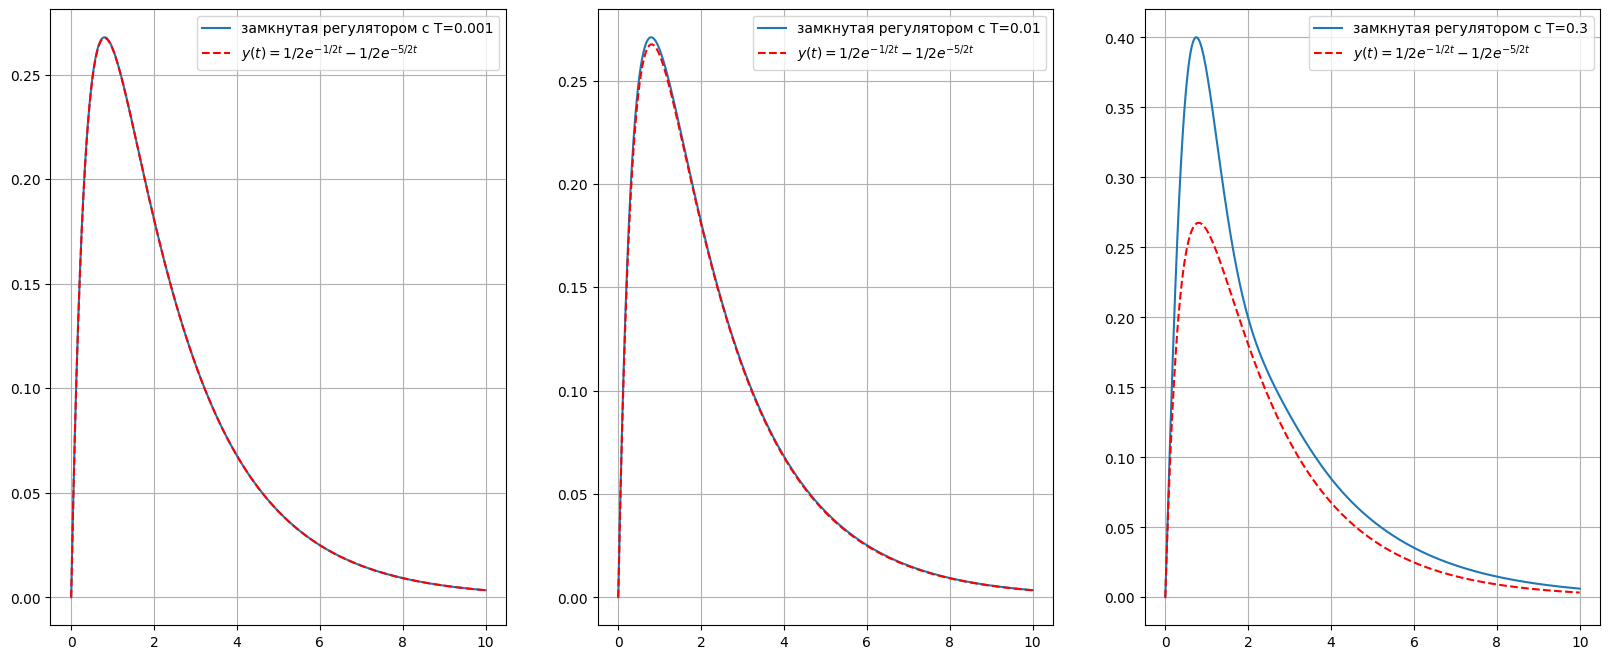

In [34]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(20,8)
)

for i in range(3):
    ax[i].plot(time, y_2[i].outputs, label=f"замкнутая регулятором с T={T_coeffs[i]}")
    ax[i].plot(time, y_an, "r--", label="$y(t) = 1/2e^{-1/2t}-1/2e^{-5/2t}$")
    ax[i].grid(True)
    ax[i].legend()

# Задание 3

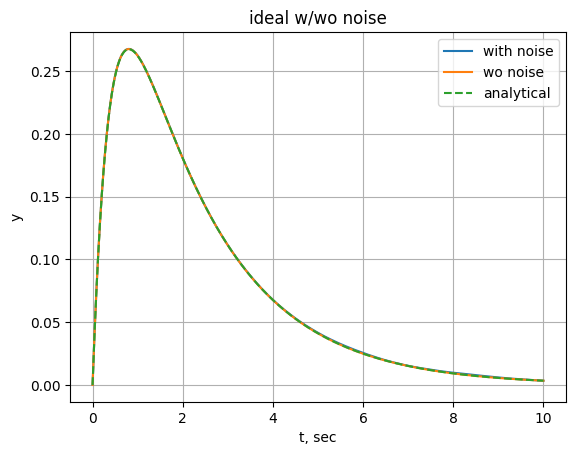

In [247]:
state = init_state_1
y_ideal_closed_noise = [state[1]]*2
for i in range(len(time)-1):
    u = k[0]*y_ideal_closed_noise[-1] + k[1] * (y_ideal_closed_noise[-1] - y_ideal_closed_noise[-2]) / dt \
        + (np.random.normal(0,0.1) if i % 10 == 0 else 0)
    response = ct.forced_response(
        sys_open,
        T=time[i:i+2],
        X0=state,
        U=u
    )
    resp = response.outputs[-1]
    y_ideal_closed_noise.append(resp)
    state = response.states[:,-1].flatten()

y_ideal_closed_noise = y_ideal_closed_noise[1:]    
plt.plot(time,y_ideal_closed_noise, label="with noise")
plt.plot(time,y_ideal_closed, label="wo noise")
plt.plot(time,y_an, linestyle="dashed", label="analytical")
plt.ylabel("y")
plt.xlabel("t, sec")
plt.title("ideal w/wo noise")
plt.grid(True)
plt.legend()

промоделируем шум как вход

In [248]:
noise = np.zeros_like(time)
for i in range(0, len(noise), 10):
    noise[i] = np.random.normal(0,0.1)

In [249]:
y_3 = [ct.forced_response(
    sys=ss,
    T=time,
    X0=set_x0(ss, init_state_2),
    U=noise
) for ss in stable_ss]

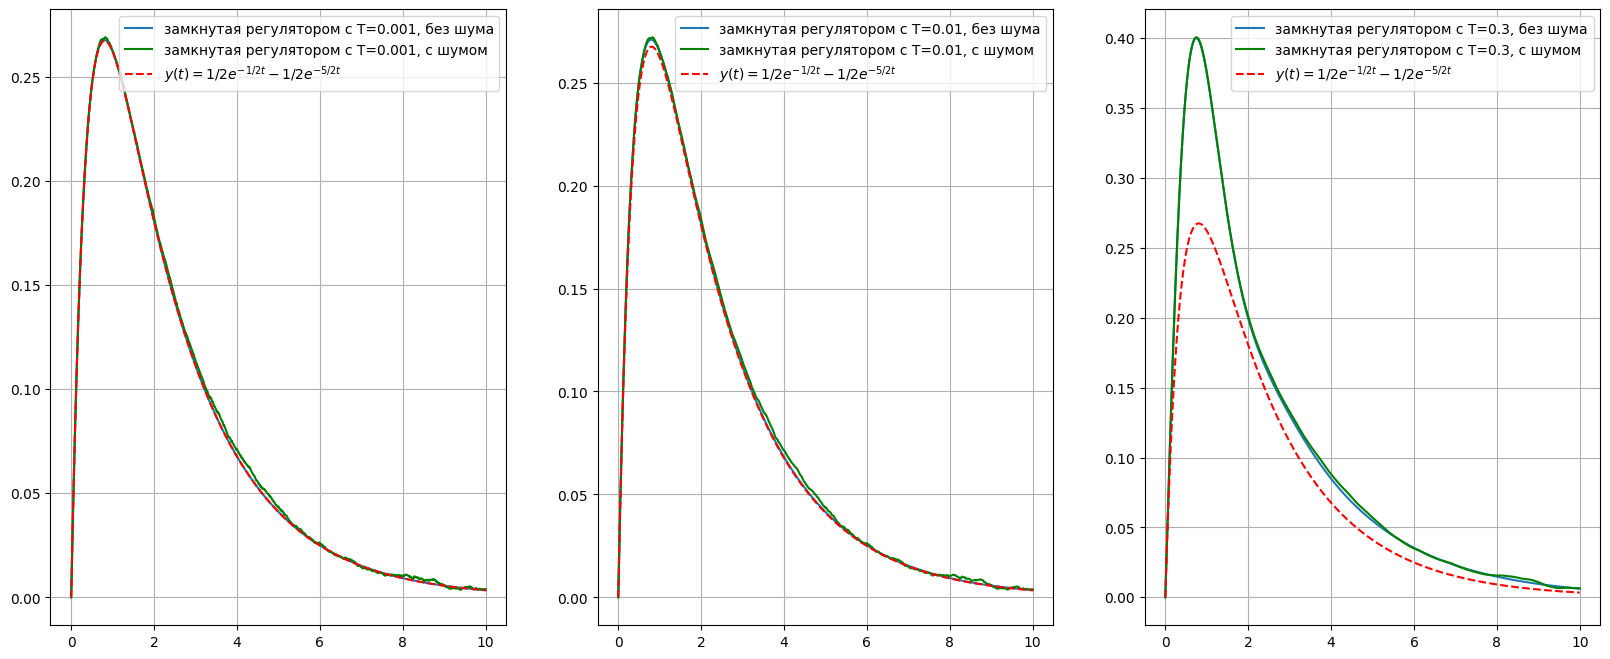

In [250]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(20,8)
)

for i in range(3):
    ax[i].plot(time, y_2[i].outputs, label=f"замкнутая регулятором с T={T_coeffs[i]}, без шума")
    ax[i].plot(time, y_3[i].outputs, label=f"замкнутая регулятором с T={T_coeffs[i]}, с шумом", color="g")
    ax[i].plot(time, y_an, "r--", label="$y(t) = 1/2e^{-1/2t}-1/2e^{-5/2t}$")
    ax[i].grid(True)
    ax[i].legend()

# Задание 4

In [279]:
b = [
    1,
    1
]
a = [
    2,
    1
]
k_4n = 200

In [280]:
k, b1, b0 = sympy.symbols('k b_1 b_0')

In [281]:
W_sys = (b1*s + b0) / (s**2 + a1*s + a0)

W_sys = W_sys.subs({
    b1: b[1],
    b0: b[0],
    a1: a[1],
    a0: a[0]
})

In [282]:
W_reg4 = k
W = W_reg4 *W_sys

In [283]:
W3 = W / (1 + W)
W3 = W3.simplify()

In [284]:
W3 = W3.subs({
    k: k_4n,
})
W3

200*(s + 1)/(s**2 + 201*s + 202)

In [285]:
alpha = 2
beta = 0.5
omega = 3
phi = 1

u1 = np.ones_like(time) * alpha
u2 = beta * time + alpha
u3 = alpha * np.sin(omega*time + phi)

us = [u1, u2, u3]

In [286]:
y4 = [
    ct.forced_response(
        sympy_frac_to_tf(W3),
        T=time,
        U=u
    ) for u in us
]

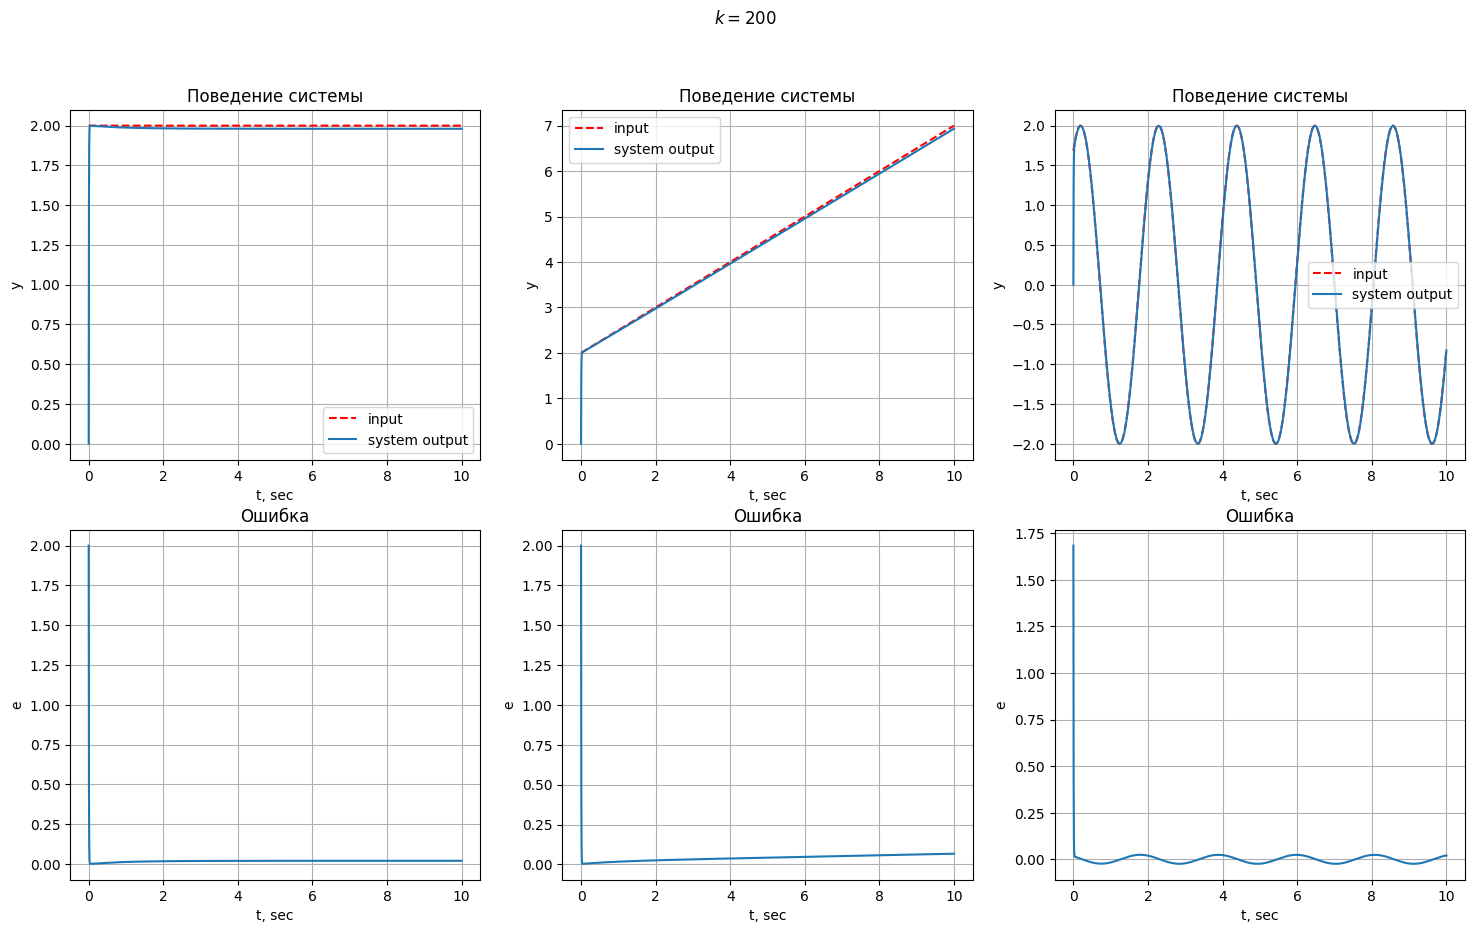

In [287]:
fig, ax = plt.subplots(2, 3, figsize=(18,10))

fig.suptitle(f"$k={k_4n}$")

for i in range(3):
    ax[0,i].plot(time, us[i],"r--", label="input")
    ax[0,i].plot(time, y4[i].outputs, label="system output")
    ax[0,i].set_title("Поведение системы")
    ax[0,i].set_xlabel("t, sec")
    ax[0,i].set_ylabel("y")
    ax[0,i].grid(True)
    ax[0,i].legend()
    
    ax[1,i].set_title("Ошибка")
    ax[1,i].set_xlabel("t, sec")
    ax[1,i].set_ylabel("e")
    ax[1,i].plot(time, us[i] - y4[i].outputs)
    ax[1,i].grid(True)

# Задание 5

In [303]:
k5 = [
    10,
    10
]

In [304]:
W_reg5 = k1/s + k0

In [305]:
W_sys5 = W_reg5 * W_sys 
W5 = W_sys5 / (1 + W_sys5)
W5 = W5.simplify()
W5 = W5.subs({
    k1: k5[1],
    k0: k5[0]
})
W5

(s + 1)*(10*s + 10)/(s*(s**2 + s + 2) + (s + 1)*(10*s + 10))

In [306]:
y5 = [
    ct.forced_response(
        sympy_frac_to_tf(W5),
        T=time,
        U=u
    ) for u in us
]

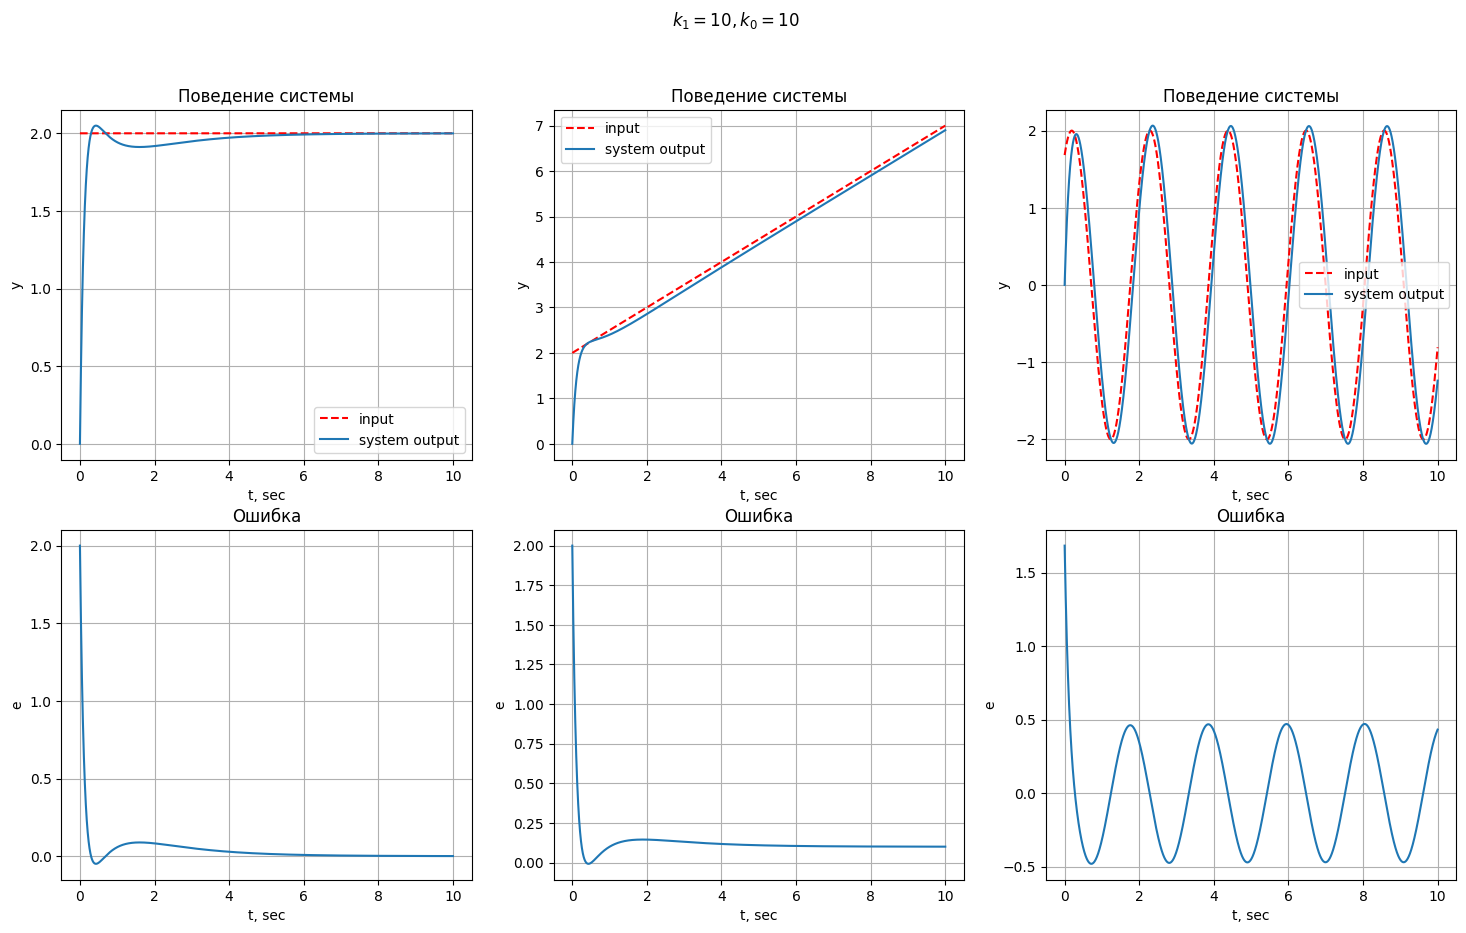

In [307]:
fig, ax = plt.subplots(2, 3, figsize=(18,10))

fig.suptitle(f"$k_1 = {k5[1]}, k_0={k5[0]}$")

for i in range(3):
    ax[0,i].plot(time, us[i],"r--", label="input")
    ax[0,i].plot(time, y5[i].outputs, label="system output")
    ax[0,i].set_title("Поведение системы")
    ax[0,i].set_xlabel("t, sec")
    ax[0,i].set_ylabel("y")
    ax[0,i].grid(True)
    ax[0,i].legend()
    
    ax[1,i].set_title("Ошибка")
    ax[1,i].set_xlabel("t, sec")
    ax[1,i].set_ylabel("e")
    ax[1,i].plot(time, us[i] - y5[i].outputs)
    ax[1,i].grid(True)

# Задание 6